In [2]:
# imports
import torch
import torchaudio
import torchaudio.transforms as aud_transforms
import torch.nn as nn
import numpy as np
import math

%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
import scipy.stats as stats

torchaudio.set_audio_backend("sox_io")

In [4]:
genre = 'blues'
number = '00001'

music_path = f"data/WAV/{genre}/{genre}.{number}.wav"

wd, sr = torchaudio.load(music_path)
resampler = aud_transforms.Resample(sr, 16000)
audio = resampler(wd).squeeze()
# wd.shape
sr, audio.shape

(22050, torch.Size([480214]))

# Differentiable transforms

## Pitch shift

In [17]:

def speedx(signal, factor):
    """ Multiplies the sound's speed by some `factor` """
    indices = torch.round( torch.range(0, len(signal), factor) )
    indices = indices[indices < len(signal)]
    return sound_array[ indices ]

def stretch(sound_array, f, window_size, h):
    """ Stretches the sound by a factor `f` """

    phase  = np.zeros(window_size)
    hanning_window = np.hanning(window_size)
    # print(len(sound_array) // f + window_size)

    result = np.zeros( int(len(sound_array) / f + window_size) )

    for i in np.arange(0, len(sound_array)-(window_size+h), h*f):
        print(sound_array.shape)
        # two potentially overlapping subarrays
        a1 = sound_array[i: i + window_size]
        a2 = sound_array[i + h: i + window_size + h]

        # resynchronize the second array on the first
        s1 =  np.fft.fft(hanning_window * a1)
        s2 =  np.fft.fft(hanning_window * a2)
        phase = (phase + np.angle(s2/s1)) % 2*np.pi
        a2_rephased = np.fft.ifft(np.abs(s2)*np.exp(1j*phase))

        # add to result
        i2 = int(i/f)
        result[i2 : i2 + window_size] += hanning_window*a2_rephased

    result = ((2**(16-4)) * result/result.max()) # normalize (16bit)

    return result.astype('int16')

def pitch_shift(snd_array, n, window_size=2**13, h=2**11):
    """ Changes the pitch of a sound by ``n`` semitones. """
    factor = 2**(1.0 * n / 12.0)
    print(factor)
    stretched = stretch(snd_array, 1.0/factor, window_size, h)
    return speedx(stretched[window_size:], factor)


In [18]:
ps_sound = pitch_shift(audio, 2)

1.122462048309373
torch.Size([480214])


TypeError: slice indices must be integers or None or have an __index__ method

## Gaussian Noise

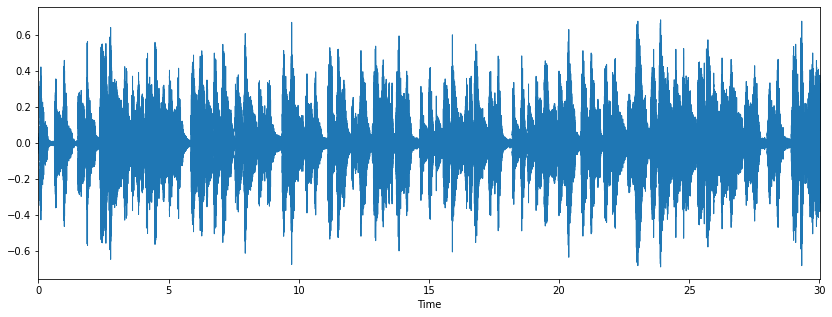

In [3]:
def display_wave(wd):
    plt.figure(figsize=(14, 5))
    librosa.display.waveplot(wd.numpy(), sr=16000)
display_wave(audio)

In [8]:
def g_noise_inj(signal, SNR):
    RMS_s = math.sqrt(np.mean(signal.numpy()**2))
    #RMS values of noise
    RMS_n=math.sqrt(RMS_s**2/(pow(10,SNR/10)))
    #Additive white gausian noise. Thereore mean=0
    #Because sample length is large (typically > 40000)
    #we can use the population formula for standard daviation.
    #because mean=0 STD=RMS
    STD_n=RMS_n
    noise = np.random.normal(0, STD_n, signal.shape[0])
    return signal + noise
    
    return torch.add(x, vals)

tensor([0.0050, 0.4621])
torch.Size([480214])


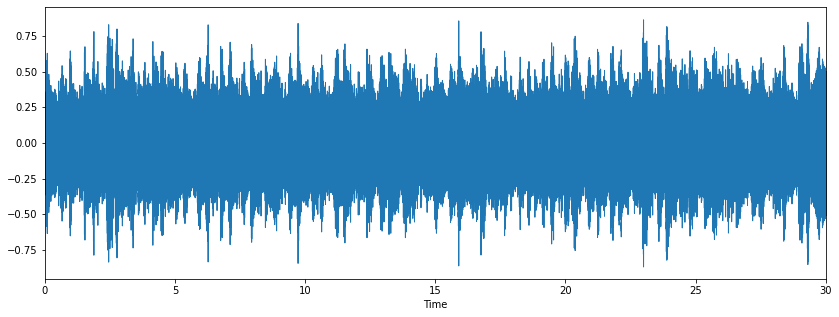

In [14]:
lim = torch.sigmoid(torch.tensor([0.01, 1.])) * 2 - 1
print(lim)
injected_audio = g_noise_inj(audio, lim[0] * 12)
print(injected_audio.shape)
display_wave(injected_audio.squeeze())

In [58]:
class GaussianNoiseAug(nn.Module):
    """
    Differetiable Gaussian noise injection
    """
    def __init__(self):
        super().__init__()
        self.aug=True
        self.log_lims = nn.Parameter(torch.tensor([1., 4.]))

    @property
    def lims(self):
        return torch.sigmoid(self.log_lims) * 2 - 1

    def forward(self, x):
        bs = x.shape[0]
        sample_length = x.shape[1]
        snr_range = torch.tensor([self.lims[0] * 3, self.lims[1] * 3])
        print(snr_range)
        g_noise = np.random.randn(sample_length)
        snr = torch.rand(bs, device=self.lims.device) * (snr_range[1] - snr_range[0]) + snr_range[0]

        noise_power = np.mean(np.power(g_noise, 2))
        sig_power = torch.mean(torch.pow(x, 2))

        snr_linear = 10**(snr / 10.0)
        noise_factor = torch.sqrt( (sig_power / noise_power) * (1 / snr_linear) )

        # noise_factor = noise_factor.unsqueeze(dim=1).expand(bs, sample_length)
        g_noise = torch.from_numpy(g_noise)
        vals = noise_factor * g_noise
        
        return torch.add(x, vals)

In [82]:
run_path = "data_interpreter/results/tp/NI"
metrics = torch.load(f"{run_path}/all_results.pt", map_location=torch.device('cpu'))#{args.epoch}


print(metrics[0]['tta_normal'].keys())



dict_keys(['no_aug', 'tta_normal', 'tta_custom'])


In [62]:
def get_accs(config_metrics):
    no_aug_acc = []
    tta_normal_acc = []
    tta_custom_acc = []
    for ind, run in enumerate(config_metrics):
        for key, val in run.items():
            if key == 'no_aug': no_aug_acc.append(val["accuracy"])
            elif key == 'tta_normal': tta_normal_acc.append(val["accuracy"])
            else: tta_custom_acc.append(val["accuracy"])
    return np.array(no_aug_acc), np.array(tta_normal_acc), np.array(tta_custom_acc)


In [73]:
def is_significant(accs, best):
    for i in range(3):
        stat, p_val = stats.wilcoxon(accs[i], best[i])
        print(stat, p_val)

In [67]:
tp_ni = get_accs(metrics)

In [75]:
no_aug_ps_metrics = torch.load(f"data_interpreter/results/no_aug/PS/all_results.pt", map_location=torch.device('cpu'))
no_aug_ps_accs = get_accs(no_aug_ps_metrics)
no_aug_ni_metrics = torch.load(f"data_interpreter/results/no_aug/NI/all_results.pt", map_location=torch.device('cpu'))
no_aug_ni_accs = get_accs(no_aug_ni_metrics)

seg_ps_metrics = torch.load(f"data_interpreter/results/segmented/PS/all_results.pt", map_location=torch.device('cpu'))
seg_ps_accs = get_accs(seg_ps_metrics)
seg_ni_metrics = torch.load(f"data_interpreter/results/segmented/NI/all_results.pt", map_location=torch.device('cpu'))
seg_ni_accs = get_accs(seg_ni_metrics)

# tp_ps_metrics = torch.load(f"{run_path}/all_results.pt", map_location=torch.device('cpu'))
# tp_ps_accs = get_accs(tp_ps_metrics)

augerino_ps_metrics = torch.load(f"data_interpreter/results/no_aug/PS/all_results.pt", map_location=torch.device('cpu'))
augerino_ps_accs = get_accs(augerino_ps_metrics)
augerino_ni_metrics = torch.load(f"data_interpreter/results/augerino/NI/all_results.pt", map_location=torch.device('cpu'))
augerino_ni_accs = get_accs(augerino_ni_metrics)


In [79]:
is_significant(tp_ni, no_aug_ps_accs)

0.0 0.0625
0.0 0.0625
0.0 0.0625


In [3]:
group1 = [20, 23, 21, 25, 18, 17, 18, 24, 20, 24, 23, 19]
group2 = [24, 25, 21, 22, 23, 18, 17, 28, 24, 27, 21, 23]

In [4]:
stats.wilcoxon(group1, group2)


/Users/somaf/Documents/python-environments/tp_project_env/lib/python3.8/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


WilcoxonResult(statistic=10.5, pvalue=0.044065400736826854)

In [6]:
(12 * 0.7649, 12 * 1.0591)
(-0.8732, 0.5606)

(-1.7464, 1.1212)